In [603]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, kron, identity
from scipy.sparse.linalg import eigsh
from tqdm import tqdm
import os

In [604]:
def get_sparse_pauli(L: int, op_char: str, site: int) -> csr_matrix:
    """Builds a single-site Pauli operator as a sparse matrix."""
    I = csr_matrix(np.eye(2, dtype=float))
    X = csr_matrix([[0, 1], [1, 0]], dtype=float)
    Z = csr_matrix([[1, 0], [0, -1]], dtype=float)
    
    ops = [I] * L
    if op_char == 'X': ops[site] = X
    elif op_char == 'Z': ops[site] = Z
    
    full_op = ops[0]
    for i in range(1, L):
        full_op = kron(full_op, ops[i], format='csr')
    return full_op

In [605]:
def get_hamiltonian_sparse(L, gx, gz):
    """
    Constructs the sparse matrix for the Ising Hamiltonian:
    H = - sum(Z_i Z_{i+1}) - g_x sum(X_i) - g_z sum(Z_i)
    (Open Boundary Conditions)
    """
    # Define Pauli Matrices
    X = np.array([[0, 1], [1, 0]])
    Z = np.array([[1, 0], [0, -1]])
    I = np.eye(2)

    # Helper to put operator at site i
    def get_term(op, site, L):
        # Kron product: I x I x ... x op x ... x I
        # We build it iteratively using sparse kron for efficiency
        ops = [I] * L
        ops[site] = op
        
        # Start with first site
        full_op = csr_matrix(ops[0])
        for k in range(1, L):
            full_op = kron(full_op, csr_matrix(ops[k]), format='csr')
        return full_op

    # Helper for Interaction Z_i Z_{i+1}
    def get_interaction(site, L):
        ops = [I] * L
        ops[site] = Z
        ops[site + 1] = Z
        
        full_op = csr_matrix(ops[0])
        for k in range(1, L):
            full_op = kron(full_op, csr_matrix(ops[k]), format='csr')
        return full_op

    # Sum terms
    # Dimensions of Hilbert space: 2^L
    dim = 2**L
    H = csr_matrix((dim, dim), dtype=float)

    # Interaction Term
    for i in range(L - 1):
        H -= get_interaction(i, L)

    # Transverse Field (X)
    if gx != 0:
        for i in range(L):
            H -= gx * get_term(X, i, L)

    # Longitudinal Field (Z)
    if gz != 0:
        for i in range(L):
            H -= gz * get_term(Z, i, L)
            
    return H

In [606]:
def analyze_spectrum_z(L: int, g_x: float, g_z_values: list[float], num_levels: int = 6):
    """
    Calculates the lowest `num_levels` energy eigenvalues for a range of g_z values.
    Returns the mass gaps m1 and m2.
    """
    mass_gaps_1 = []
    mass_gaps_2 = []
    all_levels = []

    print(f"Calculating spectrum for L={L}, g_x={g_x}")
    
    for gz in g_z_values:
        print(f"  g_z = {gz:.3f}")
        H = get_hamiltonian_sparse(L, g_x, gz)
        
        # Find lowest k eigenvalues (algebraic, 'SA' = Smallest Algebraic)
        # eigsh is efficient for sparse matrices
        eigvals, _ = eigsh(H, k=num_levels, which='SA')
        
        # Sort just in case
        eigvals = np.sort(eigvals)
        
        # E_0 is vacuum energy
        E0 = eigvals[0]
        
        # Store levels relative to vacuum
        rel_energies = eigvals - E0
        all_levels.append(rel_energies)
        
        # m1 = E1 - E0 (First particle mass)
        mass_gaps_1.append(rel_energies[1])
        
        # m2 = E2 - E0 (Second particle mass)
        mass_gaps_2.append(rel_energies[2])

    return np.array(g_z_values), np.array(mass_gaps_1), np.array(mass_gaps_2), np.array(all_levels)

In [607]:
def analyze_spectrum_x(L: int, g_x_values: list[float], g_z: float, num_levels: int = 6):
    """
    Calculates the lowest `num_levels` energy eigenvalues for a range of g_z values.
    Returns the mass gaps m1 and m2.
    """
    mass_gaps_1 = []
    mass_gaps_2 = []
    all_levels = []

    print(f"Calculating spectrum for L={L}, g_z={g_z}...")
    
    for gx in g_x_values:
        print(f"  g_x = {gx:.3f}")
        H = get_hamiltonian_sparse(L, gx, g_z) # Use OBC for standard spectrum
        
        # Find lowest k eigenvalues (algebraic, 'SA' = Smallest Algebraic)
        # eigsh is efficient for sparse matrices
        eigvals, _ = eigsh(H, k=num_levels, which='SA')
        
        # Sort just in case
        eigvals = np.sort(eigvals)
        
        # E_0 is vacuum energy
        E0 = eigvals[0]
        
        # Store levels relative to vacuum
        rel_energies = eigvals - E0
        all_levels.append(rel_energies)
        
        # m1 = E1 - E0 (First particle mass)
        mass_gaps_1.append(rel_energies[1])
        
        # m2 = E2 - E0 (Second particle mass)
        mass_gaps_2.append(rel_energies[2])

    return np.array(g_x_values), np.array(mass_gaps_1), np.array(mass_gaps_2), np.array(all_levels)

In [608]:
L = 10  # System size (keep <= 14 for laptop speed)
g_x = 1.005 # Fixed transverse field (Disordered phase > 1)
gx_values = np.linspace(1.0, 1.5, 40)  # Range of transverse fields in log scale
g_z = 0.005  # Fixed longitudinal field
gz_values = np.linspace(0.001, 0.05, 40)  # Range of longitudinal fields

In [609]:
gzs, m1s_z, m2s_z, levels_z = analyze_spectrum_z(L, g_x, gz_values)

Calculating spectrum for L=10, g_x=1.005
  g_z = 0.001
  g_z = 0.002
  g_z = 0.004
  g_z = 0.005
  g_z = 0.006
  g_z = 0.007
  g_z = 0.009
  g_z = 0.010
  g_z = 0.011
  g_z = 0.012
  g_z = 0.014
  g_z = 0.015
  g_z = 0.016
  g_z = 0.017
  g_z = 0.019
  g_z = 0.020
  g_z = 0.021
  g_z = 0.022
  g_z = 0.024
  g_z = 0.025
  g_z = 0.026
  g_z = 0.027
  g_z = 0.029
  g_z = 0.030
  g_z = 0.031
  g_z = 0.032
  g_z = 0.034
  g_z = 0.035
  g_z = 0.036
  g_z = 0.037
  g_z = 0.039
  g_z = 0.040
  g_z = 0.041
  g_z = 0.042
  g_z = 0.044
  g_z = 0.045
  g_z = 0.046
  g_z = 0.047
  g_z = 0.049
  g_z = 0.050


In [610]:
gxs, m1s_x, m2s_x, levels_x = analyze_spectrum_x(L, gx_values, g_z)

Calculating spectrum for L=10, g_z=0.005...
  g_x = 1.000
  g_x = 1.013
  g_x = 1.026
  g_x = 1.038
  g_x = 1.051
  g_x = 1.064
  g_x = 1.077
  g_x = 1.090
  g_x = 1.103
  g_x = 1.115
  g_x = 1.128
  g_x = 1.141
  g_x = 1.154
  g_x = 1.167
  g_x = 1.179
  g_x = 1.192
  g_x = 1.205
  g_x = 1.218
  g_x = 1.231
  g_x = 1.244
  g_x = 1.256
  g_x = 1.269
  g_x = 1.282
  g_x = 1.295
  g_x = 1.308
  g_x = 1.321
  g_x = 1.333
  g_x = 1.346
  g_x = 1.359
  g_x = 1.372
  g_x = 1.385
  g_x = 1.397
  g_x = 1.410
  g_x = 1.423
  g_x = 1.436
  g_x = 1.449
  g_x = 1.462
  g_x = 1.474
  g_x = 1.487
  g_x = 1.500


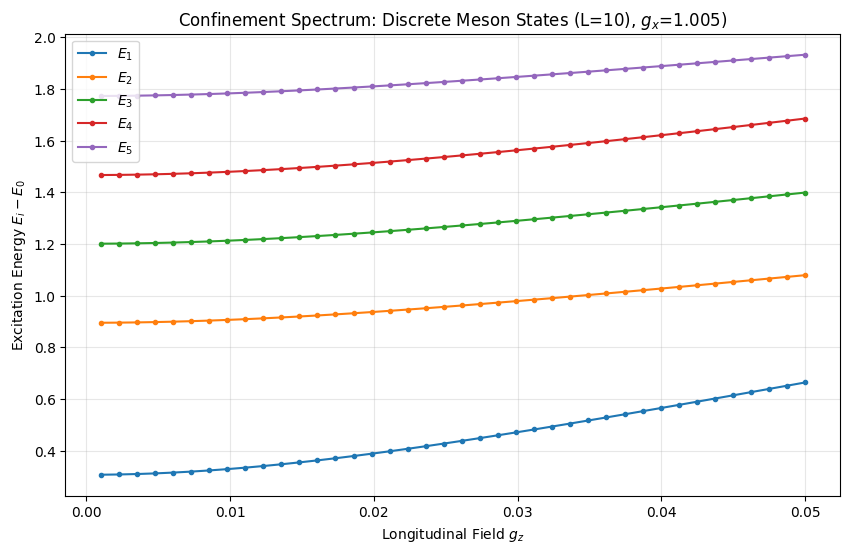

In [611]:
plt.figure(figsize=(10, 6))
    
# Transpose levels to plot E_i vs gz
levels_T = levels_z.T 
    
for i in range(1, len(levels_T)): # Skip vacuum (0)
    label = f"$E_{i}$" 
    plt.plot(gzs, levels_T[i], '.-', label=label)
        
plt.xlabel(r"Longitudinal Field $g_z$")
plt.ylabel(r"Excitation Energy $E_i - E_0$")
plt.title(f"Confinement Spectrum: Discrete Meson States (L={L}), $g_x$={g_x})")
plt.grid(True, alpha=0.3)
plt.legend()

plt.savefig(os.path.join("spectrum_plots", f"Confinement_spectrum_gx_{g_x}.png"), dpi=300)
plt.show()

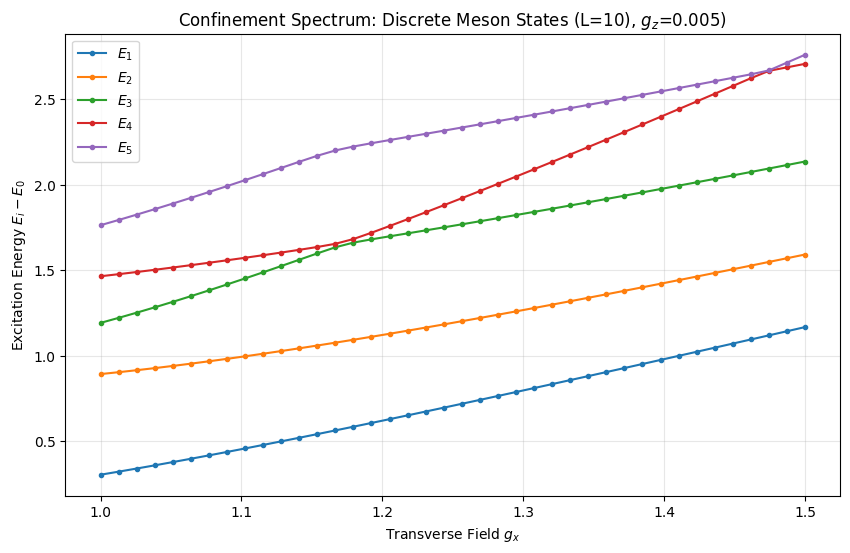

In [612]:
plt.figure(figsize=(10, 6))
    
# Transpose levels to plot E_i vs gz
levels_T = levels_x.T 
    
for i in range(1, len(levels_T)): # Skip vacuum (0)
    label = f"$E_{i}$" 
    plt.plot(gxs, levels_T[i], '.-', label=label)
        
plt.xlabel(r"Transverse Field $g_x$")
plt.ylabel(r"Excitation Energy $E_i - E_0$")
plt.title(f"Confinement Spectrum: Discrete Meson States (L={L}), $g_z$={g_z})")
plt.grid(True, alpha=0.3)
plt.legend()

plt.savefig(os.path.join("spectrum_plots", f"Confinement_spectrum_gz_{g_z}.png"), dpi=300)
plt.show()

In [613]:
def analyze_mass_ratios_fixed_gz(L, gz_fixed, gx_values):
    """
    Calculates mass ratios m_i / m_1 to visualize the stability of particles.
    """
    # We calculate the first 5 masses (m1 to m5)
    # Need k=6 eigenvalues (Vacuum + 5 excitations)
    num_eigenvalues = 10
    
    results = {
        "eta": [],
        "mass_ratios": []
    }
    
    print(f"Calculating spectrum for L={L}")
    
    for gx in tqdm(gx_values):
        # Calculate eta: eta = (gx - 1) / gz^(8/15)
        # At gx=1, eta=0
        eta = (gx - 1) / (np.abs(gz_fixed)**(8/15))
        
        H = get_hamiltonian_sparse(L, gx, gz_fixed)
        
        # Find lowest k eigenvalues
        vals, _ = eigsh(H, k=num_eigenvalues, which='SA')
        vals = np.sort(vals)
        
        # Masses are the gaps relative to vacuum
        masses = vals[1:] - vals[0]
        
        # Normalize by m1 to see particle stability (m_i / m_1)
        m1 = masses[0]
        if m1 > 1e-6:
            ratios = masses / m1
        else:
            ratios = np.zeros_like(masses) # Avoid div by zero in ferromagnetic phase
            
        results["eta"].append(eta)
        results["mass_ratios"].append(ratios)
        
    return results

In [614]:
results_zfix = analyze_mass_ratios_fixed_gz(L, g_z, gx_values)

Calculating spectrum for L=10


100%|██████████| 40/40 [00:04<00:00,  8.05it/s]


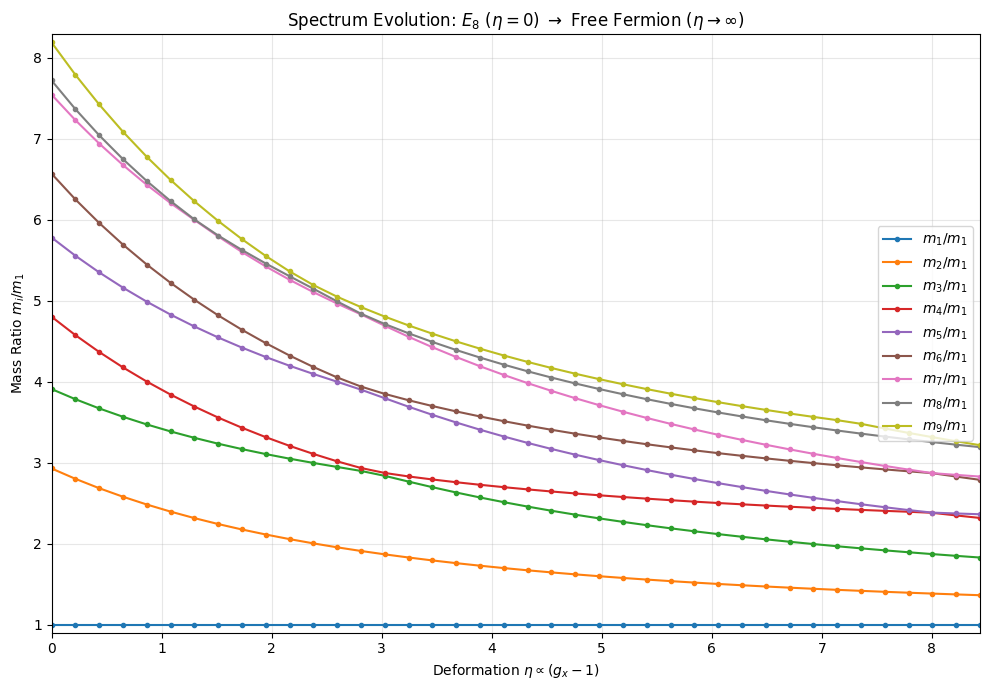

In [615]:
ratios = np.array(results_zfix["mass_ratios"]) # Shape (steps, 5)
etas = np.array(results_zfix["eta"])

plt.figure(figsize=(10, 7))
    
# Plot mass ratios m_i / m_1
for i in range(ratios.shape[1]):
    label = f"$m_{i+1} / m_1$"
    plt.plot(etas, ratios[:, i], '.-', label=label)

plt.xlabel(r"Deformation $\eta \propto (g_x-1)$")
plt.ylabel(r"Mass Ratio $m_{i} / m_1$")
plt.title("Spectrum Evolution: $E_8$ ($\\eta=0$) $\\to$ Free Fermion ($\\eta \\to \\infty$)")
plt.legend(loc='center right')
plt.grid(True, alpha=0.3)
plt.xlim(np.min(etas), np.max(etas))
plt.ylim(np.min(ratios)-0.1, np.max(ratios)+0.1)
plt.tight_layout()

plt.savefig(os.path.join("spectrum_plots", f"Mass_ratios_gz_{g_z}.png"), dpi=300)
plt.show()

In [616]:
def analyze_mass_ratios_fixed_gx(L, gx_fixed, gz_values):
    """
    Analyzes the mass spectrum for a fixed transverse field gx.
    Scans gz from small (Free Fermion-like) to large (E8-like).
    """
    
    # Storage
    num_eigenvalues = 10
    results = {"gz": [], "eta": [], "mass_ratios": []}
    
    print(f"Calculating spectrum for L={L}, fixed gx={gx_fixed}")
    
    for gz in tqdm(gz_values):
        eta = (gx_fixed - 1) / (np.abs(gz)**(8/15))
        
        H = get_hamiltonian_sparse(L, gx_fixed, gz)
        vals, _ = eigsh(H, k=num_eigenvalues, which='SA')
        vals = np.sort(vals)
        
        masses = vals[1:] - vals[0]
        m1 = masses[0]
        
        if m1 > 1e-6:
            ratios = masses / m1
        else:
            ratios = np.zeros_like(masses)
            
        results["gz"].append(gz)
        results["eta"].append(eta)
        results["mass_ratios"].append(ratios)
        
    return results

In [617]:
results_xfix = analyze_mass_ratios_fixed_gx(L, g_x, gz_values)

Calculating spectrum for L=10, fixed gx=1.005


100%|██████████| 40/40 [00:05<00:00,  7.57it/s]


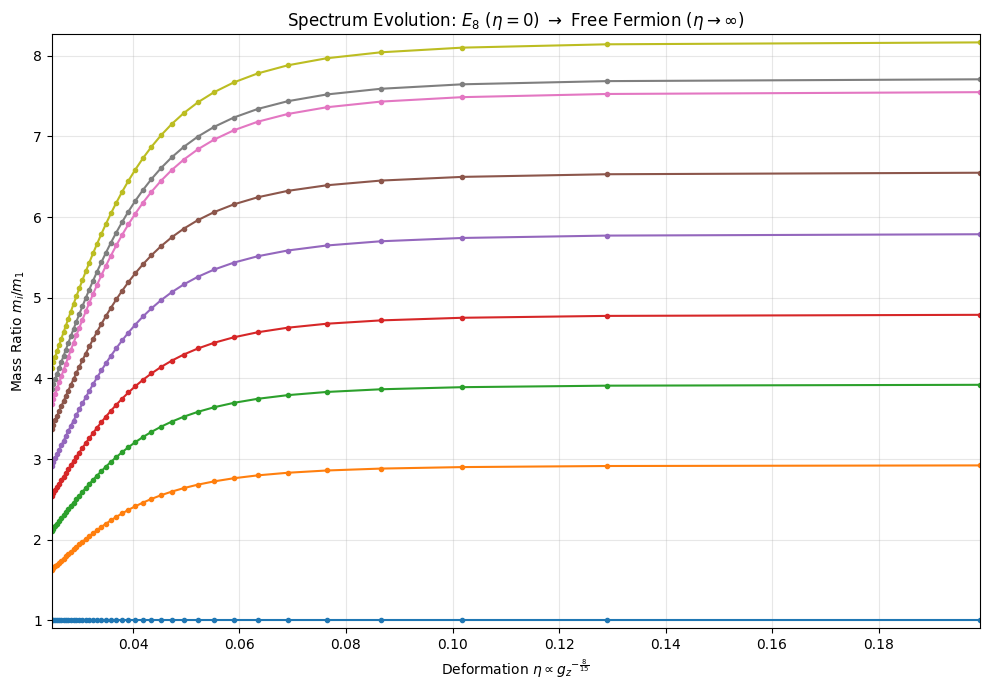

In [618]:
ratios = np.array(results_xfix["mass_ratios"])
etas = np.array(results_xfix["eta"])
    
plt.figure(figsize=(10, 7))
    
for i in range(ratios.shape[1]):
    label = f"$m_{i+1} / m_1$"
    plt.plot(etas, ratios[:, i], '.-', label=label)
    
plt.xlabel(r"Deformation $\eta \propto {g_z}^{-\frac{8}{15}}$")
plt.ylabel(r"Mass Ratio $m_{i} / m_1$")
plt.title("Spectrum Evolution: $E_8$ ($\\eta=0$) $\\to$ Free Fermion ($\\eta \\to \\infty$)")
plt.grid(True, alpha=0.3)
plt.xlim(np.min(etas), np.max(etas))
plt.ylim(np.min(ratios)-0.1, np.max(ratios)+0.1)
plt.tight_layout()
plt.savefig(os.path.join("spectrum_plots", f"Mass_ratios_gx_{g_x}.png"), dpi=300)
plt.show()